<a href="https://colab.research.google.com/github/Mbigdeli2003/Reinforcement-Learning/blob/main/RL_Sutton6_9_Windy_Grid_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Windy Grid World Problem

### importing Librariries

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### SARSA Function run episodes

In [ ]:
def run_episode(env, policy=None, render=True):
    """ Follow policy through an environment's episode and return an array of collected rewards """
    assert type(env.action_space) == gym.spaces.Discrete
    assert type(env.observation_space) == gym.spaces.MultiDiscrete

    state = env.reset()
    if render:
        env.render()

    done = False
    rewards = []
    while not done:
        state_ridx = np.ravel_multi_index(state, env.observation_space.nvec)
        action = np.argmax(policy[state_ridx])
        state, reward, done, info = env.step(action)
        rewards += [reward]

        if render:
            env.render()

    if render:
        import matplotlib.pyplot as plt
        plt.show()

    return rewards


def sarsa(env, num_episodes, eps0=0.1, alpha=0.5):
    """ On-policy Sarsa algorithm per Chapter 6.4 (with exploration rate decay) """
    assert type(env.action_space) == gym.spaces.Discrete
    assert type(env.observation_space) == gym.spaces.MultiDiscrete

    # Number of available actions and maximal state ravel index
    n_action = env.action_space.n
    n_state_ridx = np.ravel_multi_index(env.observation_space.nvec - 1, env.observation_space.nvec) + 1

    # Initialization of action value function
    q = np.zeros([n_state_ridx, n_action], dtype=np.float)

    # Initialize policy to equal-probable random
    policy = np.ones([n_state_ridx, n_action], dtype=np.float) / n_action

    history = [0] * num_episodes
    for episode in range(num_episodes):
        # Reset the environment
        state = env.reset()
        state_ridx = np.ravel_multi_index(state, env.observation_space.nvec)
        action = np.random.choice(n_action, p=policy[state_ridx])

        done = False
        while not done:
            # Step the environment forward and check for termination
            next_state, reward, done, info = env.step(action)
            next_state_ridx = np.ravel_multi_index(next_state, env.observation_space.nvec)
            next_action = np.random.choice(n_action, p=policy[next_state_ridx])

            # Update q values
            q[state_ridx, action] += alpha * (reward + q[next_state_ridx, next_action] - q[state_ridx, action])

            # Extract eps-greedy policy from the updated q values
            eps = eps0 / (episode + 1)
            policy[state_ridx, :] = eps / n_action
            policy[state_ridx, np.argmax(q[state_ridx])] = 1 - eps + eps / n_action
            assert np.allclose(np.sum(policy, axis=1), 1)

            # Prepare the next q update
            state_ridx = next_state_ridx
            action = next_action
            history[episode] += 1

    return q, policy, history

### **Windy Function**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


class WindyGridworldEnv(gym.Env):
    """ Windy Gridworld environment per Example 6.5 (defaults), Exercise 6.9 (king=True, stop=True) or
     Exercise 6.10 (king=True, stochastic=True) """
    size = (10, 7)
    start = (0, 3)
    goal = (7, 3)
    wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

    stop_action = [(0, 0)]
    pawns_actions = [(0, +1), (+1, 0), (0, -1), (-1, 0)]
    kings_action = [(+1, +1), (+1, -1), (-1, -1), (-1, +1)]

    observation_space = gym.spaces.MultiDiscrete(size)
    reward_range = (-1, -1)

    def __init__(self, king=False, stop=False, stochastic=False):
        self.stochastic = stochastic
        self.king = king
        self.stop = stop

        self.actions = self.pawns_actions[:]
        if self.king:
            self.actions += self.kings_action
        if self.stop:
            self.actions += self.stop_action
        self.action_space = gym.spaces.Discrete(len(self.actions))

        self.position = None
        self.arrow = None

        self.ax = None

    def step(self, action):
        assert self.action_space.contains(action)

        # Calculate move vector and new position
        delta = self.actions[action]
        position = self.position + np.array(delta)

        # Add wind to the position
        wind = self.wind[self.position[0]]
        if self.stochastic and wind > 0:
            wind += np.random.choice([-1, 0, +1])
        position[1] += wind

        # Store position for the next step and calculate arrow for rendering
        position = np.clip(position, 0, self.observation_space.nvec - 1)
        self.arrow = position - self.position
        self.position = position

        # Check for terminal state
        done = (position == self.goal).all()
        reward = -1

        assert self.observation_space.contains(position)
        return position, reward, done, {}

    def reset(self):
        self.position = np.array(self.start)
        self.arrow = np.array((0, 0))

        self.ax = None

        return self.position

    def render(self, mode='human'):
        if self.ax is None:
            fig = plt.figure()
            self.ax = fig.gca()

            # Background colored by wind strength
            wind = np.vstack([self.wind] * self.size[1])
            self.ax.imshow(wind, aspect='equal', origin='lower', cmap='Blues')

            # Annotations at start and goal positions
            self.ax.annotate("G", self.goal, size=25, color='gray', ha='center', va='center')
            self.ax.annotate("S", self.start, size=25, color='gray', ha='center', va='center')

            # Major tick marks showing wind strength
            self.ax.set_xticks(np.arange(len(self.wind)))
            self.ax.set_xticklabels(self.wind)
            self.ax.set_yticks([])
            self.ax.set_yticklabels([])

            # Thin grid lines at minor tick mark locations
            self.ax.set_xticks(np.arange(-0.5, self.size[0]), minor=True)
            self.ax.set_yticks(np.arange(-0.5, self.size[1]), minor=True)
            self.ax.grid(which='minor', color='black', linewidth=0.20)
            self.ax.tick_params(which='both', length=0)
            self.ax.set_frame_on(True)

        # Arrow pointing from the previous to the current position
        if (self.arrow == 0).all():
            patch = mpatches.Circle(self.position, radius=0.05, color='black', zorder=1)
        else:
            patch = mpatches.FancyArrow(*(self.position - self.arrow), *self.arrow, color='black',
                                        zorder=2, fill=True, width=0.05, head_width=0.25,
                                        length_includes_head=True)
        self.ax.add_patch(patch)


gym.envs.registration.register(
    id='WindyGridworld-v0',
    entry_point=lambda king, stop, stochastic: WindyGridworldEnv(king, stop, stochastic),
    kwargs={'king': False, 'stop': False, 'stochastic': False},
    max_episode_steps=5_000,
)

### buliding the environmnet using gym an applying sarsa

In [ ]:
env = gym.make('WindyGridworld-v0')
q, policy, history = sarsa(env, 1500, eps0=0.1, alpha=0.5)

<ipython-input-51-1cf2af8bdac5>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  q = np.zeros([n_state_ridx, n_action], dtype=np.float)


### Plotting the Example Results

In [ ]:
#Action Values
matplotlib.rcParams['figure.figsize'] = [10, 10]
def plot_results(env, q, policy):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title("Optimal Value Function and Policy")

    q = np.copy(q)
    unvisited = np.where(q == 0)
    q[unvisited] = -np.inf
    v = np.max(q, axis=1).reshape(env.observation_space.nvec)
    ax.imshow(v.T, origin='lower')

    a_stars = np.argmax(policy, axis=1)
    arrows = np.array([env.actions[a] for a in a_stars])
    arrows[unvisited[0], :] = 0
    arrows = arrows.reshape([*env.observation_space.nvec, 2])
    xr = np.arange(env.observation_space.nvec[0])
    yr = np.arange(env.observation_space.nvec[1])
    ax.quiver(xr, yr, arrows[:, :, 0].T, arrows[:, :, 1].T, pivot='mid')

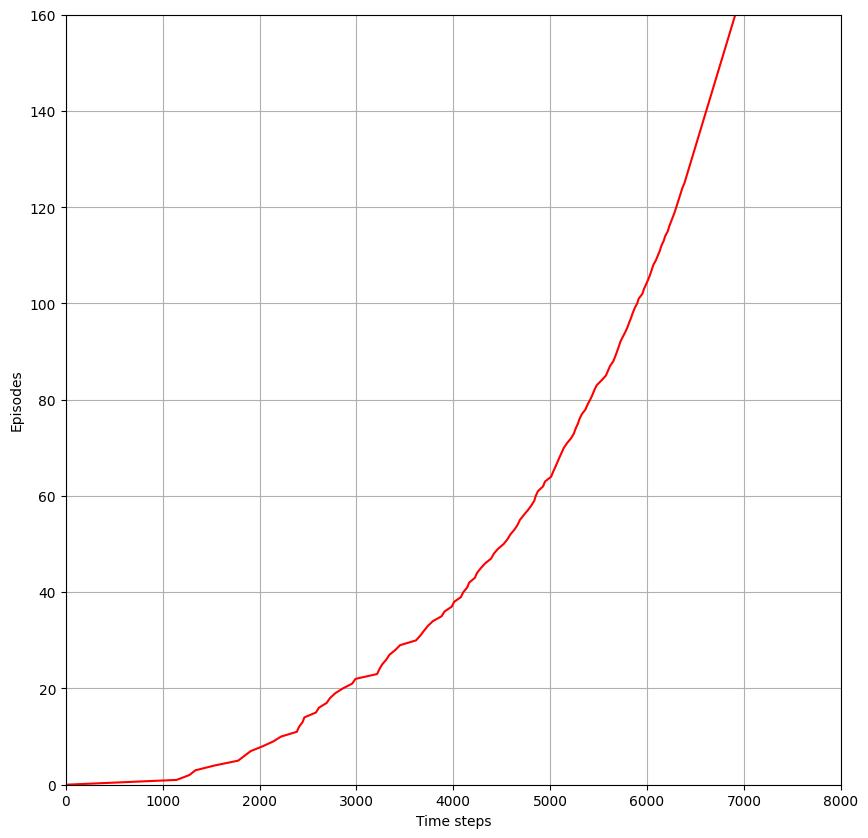

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


<Figure size 1000x1000 with 0 Axes>

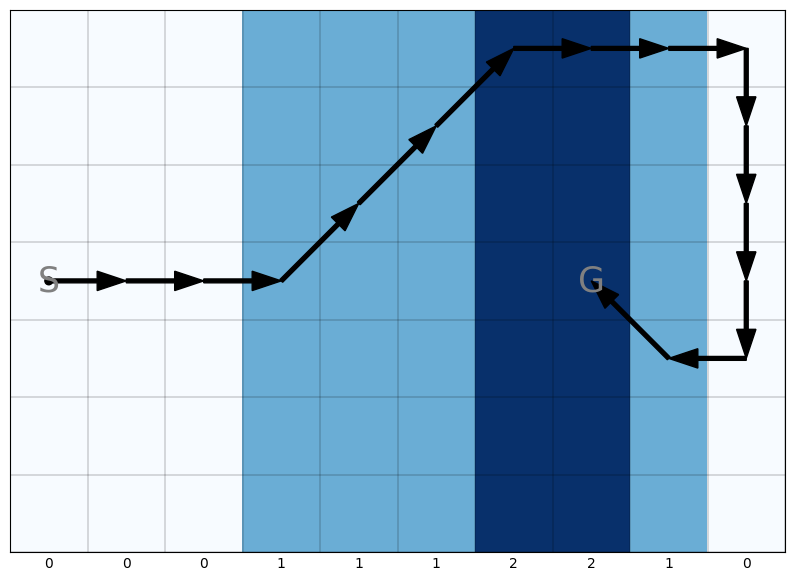

Episode length = 15


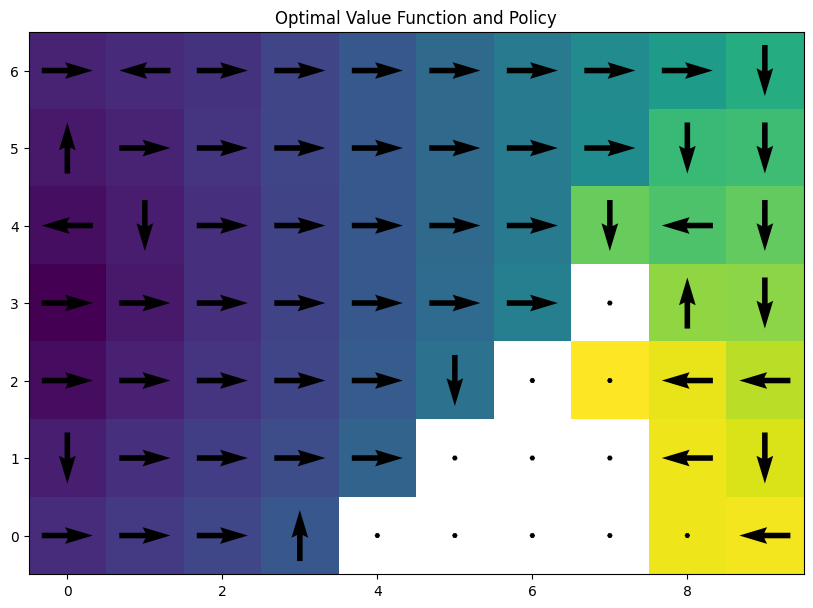

In [ ]:
#Time Steps -Episodes
plt.figure()
plt.grid()
plt.xlabel("Time steps"); plt.xlim(0, 8_000)
plt.ylabel("Episodes"); plt.ylim(0, 160)
timesteps = np.cumsum([0] + history)
plt.plot(timesteps, np.arange(len(timesteps)), color='red')
plt.show()

#Rewards
plt.figure()
rewards = run_episode(env, policy, render=True)
print(f"Episode length = {len(rewards)}")
#Optimal Value and Policy
plot_results(env, q, policy)